# Fetching data from database

In [1]:
# Fetching data from Google Sheets
import gspread
import pandas as pd
from google.auth import default
from google.colab import auth
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
spreadsheet = gc.open_by_key('1EH95aGJZQTrfI6G-5Hx73yCgkbQTKzk1QX_YJ9E7Dlk')
worksheet = spreadsheet.get_worksheet(0)
df = pd.DataFrame(worksheet.get_all_records())
# Prints first 6 tuples
print(df[:6])

   id                 date  temperature  humidity  eco2  tvoc
0   1  12/12/2025 15:40:54           22        47   400     0
1   2  12/12/2025 15:41:28           22        47   400     0
2   3  12/12/2025 15:42:03           22        47   402     0
3   4  12/12/2025 15:42:37           22        47   401     0
4   5  12/12/2025 15:43:12           22        47   400     0
5   6  12/12/2025 15:43:46           22        47   400     0


# Necessary Imports

In [2]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import keras
import numpy as np

# Determining current GPU

In [3]:
# Test for GPU and determine what GPU we have
import platform
import subprocess
gpu_devices = tf.config.list_physical_devices('GPU')

gpu_name = tf.test.gpu_device_name()
if gpu_name != '':
    print('TF-GPU-devname:',tf.test.gpu_device_name())
    sys_details = tf.sysconfig.get_build_info()
    physical_devices = tf.config.list_physical_devices('GPU')
    print("Num GPUs:", len(physical_devices))
    if platform.system() == "Darwin":
        print('GPU on Mac!')
    else:
        cuda_version = sys_details["cuda_version"]
        print('TF-cuda version:',cuda_version)
        if len(physical_devices)>0:
            process = subprocess.Popen(['nvidia-smi','-L'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            print(process.communicate())
        # If possible to run code with 16 bits float instead of 32 bits float, this code activates such functionality:
        if gpu_devices:
            details = tf.config.experimental.get_device_details(gpu_devices[0])
            compute_capability=details.get('compute_capability')
            print("Compute capability:",compute_capability)
            if compute_capability[0]>6:
                print("Turning on mixed_float16")
                policy = keras.mixed_precision.Policy('mixed_float16')
                keras.mixed_precision.set_global_policy(policy)
else:
    print('TF-device CPU')

TF-device CPU


# Exploring the data

In [4]:
print("Amount of rows in dataset:", df.shape[0])
print("Amount of attributes in dataset:", df.shape[1])

df.head()

Amount of rows in dataset: 14975
Amount of attributes in dataset: 6


,id,date,temperature,humidity,eco2,tvoc
0,1,12/12/2025 15:40:54,22,47,400,0
1,2,12/12/2025 15:41:28,22,47,400,0
2,3,12/12/2025 15:42:03,22,47,402,0
3,4,12/12/2025 15:42:37,22,47,401,0
4,5,12/12/2025 15:43:12,22,47,400,0


# Exploring a few attributes evolution over time

Index(['id', 'date', 'temperature', 'humidity', 'eco2', 'tvoc'], dtype='object')


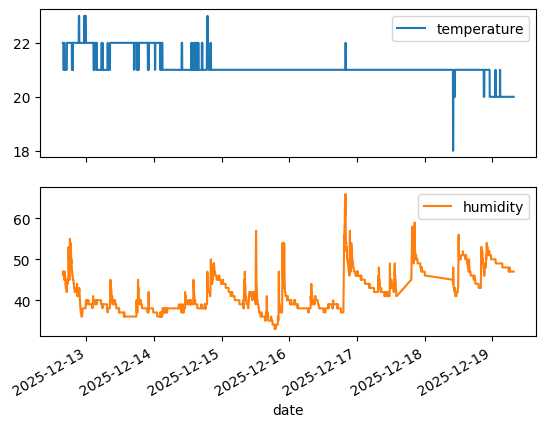

In [5]:

print(df.columns)
df['date'] = pd.to_datetime(df['date'], dayfirst=True, format='mixed')
df = df.set_index('date')

plot_cols = ['temperature', 'humidity']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True)


# Inspect and cleanup of dataset

In [6]:
# Remove irrelevant id attribute
df = df.drop(columns=['id'])

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temperature,14975.0,21.151452,0.518942,18.0,21.0,21.0,21.0,23.0
humidity,14975.0,41.736427,4.817053,33.0,38.0,40.0,45.0,66.0
eco2,14975.0,412.594324,85.358991,400.0,400.0,400.0,400.0,3699.0
tvoc,14975.0,29.503506,169.538250,0.0,0.0,0.0,0.0,10706.0


**The data looks clean, no outliers 🙂**

# When measuring the data I noticed that the RPI Pico stopped measuring at two points of time due to exceeded memory.

# This is why we need to find the gaps in the dataset where no measures were made every 30-35 seconds. (I chose to filter through when no measures were made in 90 seconds instead of 30-35 because sometimes the data post took about 1 minute due to slow routing)

In [7]:
df = df.sort_index()

gaps = pd.DataFrame({
  "before": df.index.to_series().shift(1),
  "after": df.index,
  "gap": df.index.to_series().diff(),
  "row_ix": range(len(df))
})

# Threshold for minimum gap to be measured
threshold = pd.Timedelta(seconds=90)

# Defining missed measures where the time inbetween two measures are greater than 90 seconds
gaps = gaps[gaps["gap"] > threshold]

display(gaps)

,before,after,gap,row_ix
date,,,,
2025-12-17 14:10:22,2025-12-17 14:05:33,2025-12-17 14:10:22,0 days 00:04:49,12229
2025-12-17 19:14:13,2025-12-17 14:10:22,2025-12-17 19:14:13,0 days 05:03:51,12230
2025-12-18 10:03:48,2025-12-18 00:30:59,2025-12-18 10:03:48,0 days 09:32:49,12774


**We found three larger gaps in the dataset**

**Gap 1: 5 minutes**

**Gap 2: 5 hours**

**Gap 3: 9.5 hours**

# Adding the missing values

**The most recent values measured will be applied for all missed measurments for the respective gap**

**The three indexes where the gaps are in the dataset**

In [8]:
indexOfGaps = gaps['row_ix'].tolist()

print(indexOfGaps)

[12229, 12230, 12774]


**The RPI Pico is programmed to measure every 30 seconds, but sending data to google sheets adds a few seconds, irregurlary.**

**In order to add the correct amount missing data, I need to find the average time in between measurements.**

In [9]:
# Filtering out the larger gaps from the dataset.
time_diff = df.index.to_series().diff()

valid_measurements = time_diff[time_diff <= threshold]

print(valid_measurements)
print()

# Calculating the average value of each time difference
avg_valid_measurements = valid_measurements.dt.total_seconds().mean()

print(f'Average time between measurements {avg_valid_measurements:.2f}')

date
2025-12-12 15:41:28   0 days 00:00:34
2025-12-12 15:42:03   0 days 00:00:35
2025-12-12 15:42:37   0 days 00:00:34
2025-12-12 15:43:12   0 days 00:00:35
2025-12-12 15:43:46   0 days 00:00:34
                            ...      
2025-12-19 07:37:03   0 days 00:00:34
2025-12-19 07:37:40   0 days 00:00:37
2025-12-19 07:38:15   0 days 00:00:35
2025-12-19 07:38:50   0 days 00:00:35
2025-12-19 07:39:24   0 days 00:00:34
Name: date, Length: 14971, dtype: timedelta64[ns]

Average time between measurements 34.94


# Let us explore about how many measures were missed.

**Gap 1: (5 * 60) / 35**

**Gap 2: (5 * 60 * 60) / 35**

**Gap 3: (9.5 * 60 * 60) / 35**

**Gap 1 resulted in 9 missed measures.**

**Gap 2 resulted in 514 missed measures.**

**Gap 3 resulted in 977 missed measures.**

**Notice that when I found the three gaps I disregarded smaller gaps, shorter than 90 seconds.**

**Below all of these smaller gaps will be filled as well as the larger ones.**

In [10]:
df_35s = df.resample("35s").mean()
df_filled = df_35s.ffill()
df_filled["is_imputed"] = df_35s.isna().any(axis=1)

print(df)
print(df_filled)


                     temperature  humidity  eco2  tvoc
date                                                  
2025-12-12 15:40:54           22        47   400     0
2025-12-12 15:41:28           22        47   400     0
2025-12-12 15:42:03           22        47   402     0
2025-12-12 15:42:37           22        47   401     0
2025-12-12 15:43:12           22        47   400     0
...                          ...       ...   ...   ...
2025-12-19 07:37:03           20        47   400     0
2025-12-19 07:37:40           20        47   400     0
2025-12-19 07:38:15           20        47   400     0
2025-12-19 07:38:50           20        47   400     0
2025-12-19 07:39:24           20        47   400     0

[14975 rows x 4 columns]
                     temperature  humidity   eco2  tvoc  is_imputed
date                                                               
2025-12-12 15:40:20         22.0      47.0  400.0   0.0       False
2025-12-12 15:40:55         22.0      47.0  400.0   0.0

**Notice that another attribute was added to the dataset, *is_imputed*.**

**The attribute consits of a boolean value, True or False.**

**If the attribute is added by Last Measured Value-principle the is_imputed value is True, otherwise false.**

**This attribute helps the LSTM-model to recognize if the value is "natural" or added afterwards, as in this case regarding the gaps.**

**The original dataset consists of 14 976 rows.**

**The filled dataset consists of 16 456 rows**

**The dataset increased of 16456 - 14976 = 1480 rows**

# We want to predict 1 hour into the future, so we divide the dataset into 1 hour steps

In [11]:
df_1h = df.resample("1h").mean()
df_1h = df_1h.dropna() # Remove all NaN tuples
print("Amount of rows with 1 hour windows:", len(df_1h))

Amount of rows with 1 hour windows: 148


# Normalize the data

In [12]:
# Split the data into datasets
DataSplitRatios = (0.7, 0.2, 0.1)
n = len(df_1h)
split1ix = int(n*DataSplitRatios[0])
split2ix = int(n*(DataSplitRatios[0] + DataSplitRatios[1]))
print(split1ix, split2ix, n)

103 133 148


It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature. Note that the mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

The data is normalized so that the data is in the same distribution which makes the models to be able to learn easier (Tomas Nordström, 2025-05-08).

In [13]:
train_mean = df_1h[0:split1ix].mean()
train_std = df_1h[0:split1ix].std()
dfnorm = (df_1h - train_mean) / train_std

# Exploring distribution of normalized features

/tmp/ipython-input-1120103389.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df_1h.keys(), rotation=45)


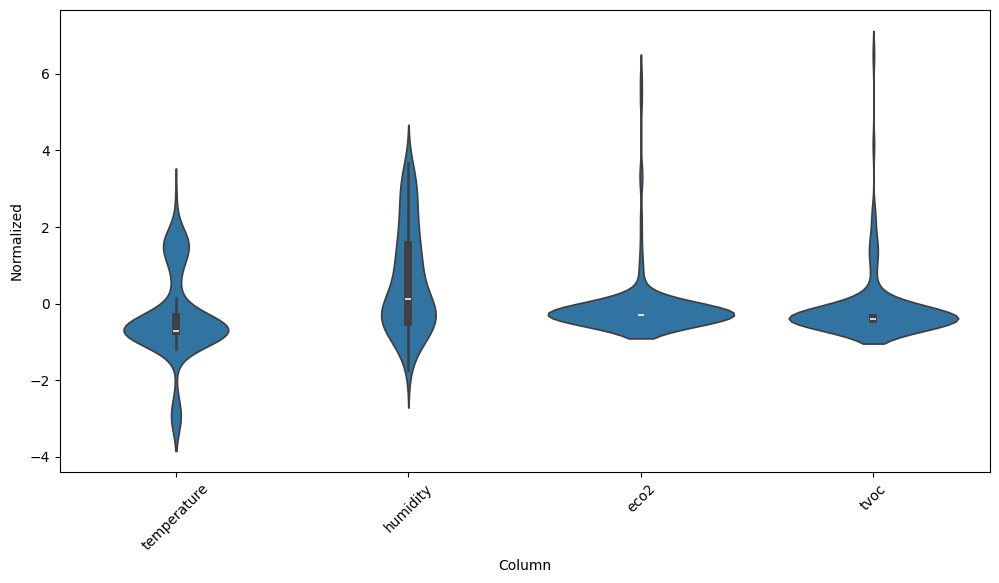

In [14]:
import seaborn as sns

df_std = dfnorm.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df_1h.keys(), rotation=45)

# Prepare our three datasets

In [15]:
def get_label_columns_indices(dataframe, label_columns=None):
    """
    Returns a dictionary mapping column names to their indices in the given DataFrame.
    Parameters:
        dataframe : pandas.DataFrame
            The DataFrame from which to extract column indices.
        label_columns : list of str, optional
            A list of column names to retrieve indices for. If None, all columns will be included.
    Returns:
        A dictionary where keys are column names and values are their corresponding indices.
    """
    if label_columns is None:
        # Return indices for all columns
        label_columns_indices = {name: i for i, name in enumerate(dataframe.columns)}
    else:
        # Return indices only for the specified label columns
        label_columns_indices = {name: dataframe.columns.get_loc(name) for name in label_columns}
    return label_columns_indices

In [16]:
# Test get_label_columns_indices
lcol= None
lci = get_label_columns_indices(dfnorm,lcol)
print(lci)
lcol= lcol= ['temperature']
lci = get_label_columns_indices(dfnorm,lcol)
print(lci)

{'temperature': 0, 'humidity': 1, 'eco2': 2, 'tvoc': 3}
{'temperature': 0}


In [17]:
# Define a windowing function that converts a dataframe into a TF dataset
# Had to jump to some hoops for this as keras.utils.timeseries_dataset_from_array do not support label_width>1
# https://github.com/keras-team/tf-keras/issues/7
def datasetgen(dataframe, input_width=128, label_width=1, shift=1, batch_size=128,
  label_columns=None, start_index=None, end_index=None, shuffle=False):
  """
  Generate timeseries dataset from the given dataframe containing a data sequence.

  Parameters:
  - dataframe: The source time sequence dataframe.
  - input_width: Number of time steps in each input sequence.
  - label_width: Number of time steps in each label sequence.
  - shift: How many steps to shift the end of the input to get the label.
  - batch_size: Size of batches to generate.
  - label_columns: List of column names to extract as labels. If None, all columns are used.
  - start_index: Start index from the dataframe to consider data. Default is the start of the dataframe.
  - end_index: End index from the dataframe to consider data. Default is the end of the dataframe.
  - shuffle: Whether to shuffle the generated batches. Note: shuffling won't work in the current implementation.

  Returns:
  - A TensorFlow Dataset containing input and label sequences.
  """

  # If end index or start index is not given, assign them to the end or start of the dataframe respectively.
  if end_index is None:
      end_index = len(dataframe) + input_width - 1
  if start_index is None:
      start_index = 0

  # Generate a input timeseries dataset from the dataframe using keras.utils.timeseries_dataset_from_array
  input_ds = keras.utils.timeseries_dataset_from_array(
                  dataframe, targets=None, sequence_length=input_width,
                  sequence_stride=1, sampling_rate=1, batch_size=batch_size, shuffle=shuffle,
                  start_index=start_index, end_index=(end_index-(input_width+shift)))

  # Fetch the indices of the label columns from the dataframe.
  label_columns_indices = get_label_columns_indices(dataframe,label_columns) # get the selected columns
  targetsdf = dataframe[list(label_columns_indices)] # Note that we only use names and not the indices

  # Generate a timeseries dataset of label sequences from the dataframe.
  # Here we assume that label_width should be less than or equal to shift.
  target_ds = keras.utils.timeseries_dataset_from_array(
                  targetsdf, targets=None, sequence_length=label_width,
                  sequence_stride=1, sampling_rate=1, batch_size=batch_size, shuffle=shuffle,
                  start_index=(start_index+(input_width+shift-label_width)),
                  end_index=end_index-input_width)

  # Combine input and target datasets to form a single dataset.
  train_ds = tf.data.Dataset.zip(input_ds,target_ds)

  return train_ds

In [18]:
# Split targets

def split_targets(inputs, targets):
    targets = tf.squeeze(targets, axis=1)  # (batch, 4)
    return inputs, {
        "temperature": targets[:, 0],
        "humidity":  targets[:, 1],
        "eco2": targets[:, 2],
        "tvoc": targets[:, 3],
    }

In [19]:
# Now create the used datasets

input_width=12
shift=1           # How many steps to target
label_width=1     # Target sequence length
lcol=['temperature', 'humidity', 'eco2', 'tvoc'] # Target parameter(s)
train_ds = datasetgen(dfnorm, input_width=input_width, label_width=label_width, shift=shift,
              label_columns=lcol, start_index=0, end_index=split1ix)
val_ds = datasetgen(dfnorm, input_width=input_width, label_width=label_width, shift=shift,
              label_columns=lcol, start_index=split1ix, end_index=split2ix)
test_ds = datasetgen(dfnorm, input_width=input_width, label_width=label_width, shift=shift,
              label_columns=lcol, start_index=split2ix, end_index=None)

train_ds = train_ds.map(split_targets)
val_ds   = val_ds.map(split_targets)
test_ds  = test_ds.map(split_targets)

In [20]:
# Establish test targets (to show how to unroll dataset)
# Discussed with ChatGPT how to transform target establishing from one target to 4.

test_targets = {
    "temperature": [],
    "humidity": [],
    "eco2": [],
    "tvoc": []
}
for inputs, targets in test_ds:
  for x in test_targets:
    test_targets[x].append(targets[x])

for x in test_targets:
  test_targets[x] = tf.concat(test_targets[x], axis=0)

In [21]:
# Get a batch and look at the shapes for one of the datasets
eval_ds = test_ds

for inputs, targets in eval_ds.take(1):
  for key, value in targets.items():
    print(key, value.shape)

temperature (2,)
humidity (2,)
eco2 (2,)
tvoc (2,)


# Finally the datasets are ready for training

**Exploring loss function**

Defining method for compiling and fitting data

In [22]:
# For reference when compiling a multile output LSTM: https://keras.io/guides/functional_api/

import time

def compile_and_fit(model, train_ds, val_ds, patience=5):
  MAX_EPOCHS = 30
  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights = True)

  model.compile(optimizer=tf.optimizers.Adam(),
                loss={
                    "temperature": "mse",
                    "humidity": "mse",
                    "eco2": "mse",
                    "tvoc": "mse"
                },
                loss_weights={
                  "temperature": 1.0,
                  "humidity": 1.0,
                  "eco2": 0.5,
                  "tvoc": 0.3
                },
                metrics={
                    "temperature": "mae",
                    "humidity": "mae",
                    "eco2": "mae",
                    "tvoc": "mae"
                }
              )

  start = time.time()
  history = model.fit(train_ds, epochs=MAX_EPOCHS,
                      validation_data=val_ds,
                      callbacks=[early_stopping])
  end = time.time()
  print(f'Time to run: {end - start:.1f}s')

  return history,model

# Creating a model

In [23]:
# Define a LSTM-model with multiple outputs
# For reference when creating a multile output LSTM: https://keras.io/guides/functional_api/

num_input_features = dfnorm.shape[1]

inputs = keras.Input(shape=(input_width, num_input_features))
lstm_layer = keras.layers.LSTM(64, return_sequences=False)(inputs)

temp = keras.layers.Dense(1, name="temperature")(lstm_layer)
hum = keras.layers.Dense(1, name="humidity")(lstm_layer)
eco2 = keras.layers.Dense(1, name="eco2")(lstm_layer)
tvoc = keras.layers.Dense(1, name="tvoc", activation="relu")(lstm_layer) # Realized i predicted negative tvoc values, which is physically impossible. References: https://www.reddit.com/r/learnmachinelearning/comments/eisotm/what_is_the_best_way_to_deal_with_negative/ & https://keras.io/api/layers/core_layers/dense/

lstm_model = keras.Model(
    inputs = inputs,
    outputs = [temp, hum, eco2, tvoc]
)

**Compile and train model**

In [24]:
history_lstm_model, lstm_model=compile_and_fit(lstm_model, train_ds, val_ds)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - eco2_loss: 0.5412 - eco2_mae: 0.3814 - humidity_loss: 0.5313 - humidity_mae: 0.5724 - loss: 1.7969 - temperature_loss: 0.6779 - temperature_mae: 0.7543 - tvoc_loss: 1.0570 - tvoc_mae: 0.6318 - val_eco2_loss: 0.1217 - val_eco2_mae: 0.3486 - val_humidity_loss: 2.4563 - val_humidity_mae: 1.1497 - val_loss: 2.8044 - val_temperature_loss: 0.1941 - val_temperature_mae: 0.4404 - val_tvoc_loss: 0.3106 - val_tvoc_mae: 0.5573
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - eco2_loss: 0.5354 - eco2_mae: 0.3761 - humidity_loss: 0.5153 - humidity_mae: 0.5593 - loss: 1.7319 - temperature_loss: 0.6327 - temperature_mae: 0.7262 - tvoc_loss: 1.0539 - tvoc_mae: 0.6287 - val_eco2_loss: 0.1105 - val_eco2_mae: 0.3321 - val_humidity_loss: 2.4331 - val_humidity_mae: 1.1387 - val_loss: 2.7369 - val_temperature_loss: 0.1604 - val_temperature_mae: 0.4004 - val_tvoc_loss: 0.2938 - val_tvoc_mae: 0.5420
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - eco2_

**Evaluate model**

In [25]:
results = lstm_model.evaluate(test_ds, verbose=0, return_dict=True)

for key, value in results.items():
  print(f"{key}, {value:.4f}\n")

eco2_loss, 0.0148

eco2_mae, 0.1214

humidity_loss, 1.3749

humidity_mae, 1.1702

loss, 4.2206

temperature_loss, 2.7872

temperature_mae, 1.6692

tvoc_loss, 0.1707

tvoc_mae, 0.4132



# Converting the normalized evaluated units to real units

In [26]:
# Discussed with ChatGPT how to convert normalized units to real

for key, value in results.items():
    if key.endswith("_mae"):
        var = key.replace("_mae", "")
        mae_real = value * train_std[var]
        print(f"{var}: MAE: {mae_real:.2f} (real units)\n")

eco2: MAE: 7.55 (real units)

humidity: MAE: 4.01 (real units)

temperature: MAE: 0.72 (real units)

tvoc: MAE: 41.31 (real units)



# Example plot of predictions

In [27]:
# Define a plot function to show how well it is predicting
# Transformed show_plot method from Laboration 3 in discussion with ChatGPT

def show_plot(history, true_future, model_prediction, title):

    time_steps = range(-len(history), 0)

    plt.figure(figsize=(8,4))
    plt.plot(time_steps, history, '.-', label='History')
    plt.plot(1, true_future, 'rx', markersize=6, label='True Future')
    plt.plot(1, model_prediction, 'go', markersize=6, label='Model Prediction')

    plt.legend()
    plt.title(title)
    plt.ylabel("Normalized value")
    plt.xlabel("Time-Step")
    plt.grid(True)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


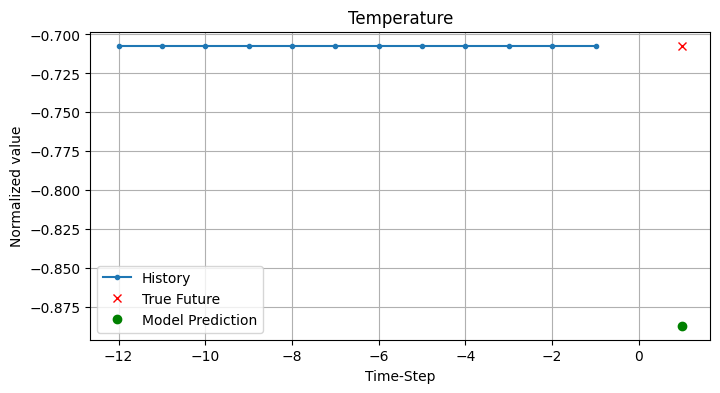

In [28]:
# @title
for x, y in val_ds.take(3):
  predictions = lstm_model.predict(x)
  show_plot(
        x[0, :, 0].numpy(),              # history (time_steps,)
        y["temperature"][0].numpy(),     # true future
        predictions[0][0][0],            # model prediction
        "Temperature"
        )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


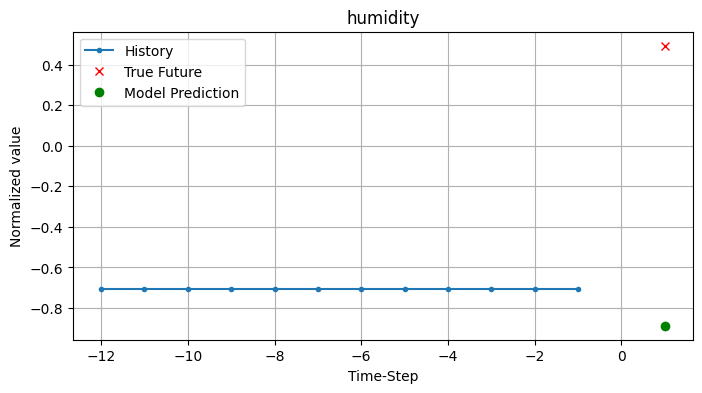

In [29]:
# @title
for x, y in val_ds.take(3):
  predictions = lstm_model.predict(x)
  show_plot(
        x[0, :, 0].numpy(),              # history (time_steps,)
        y["humidity"][0].numpy(),        # true future
        predictions[0][0][0],            # model prediction
        "humidity"
        )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


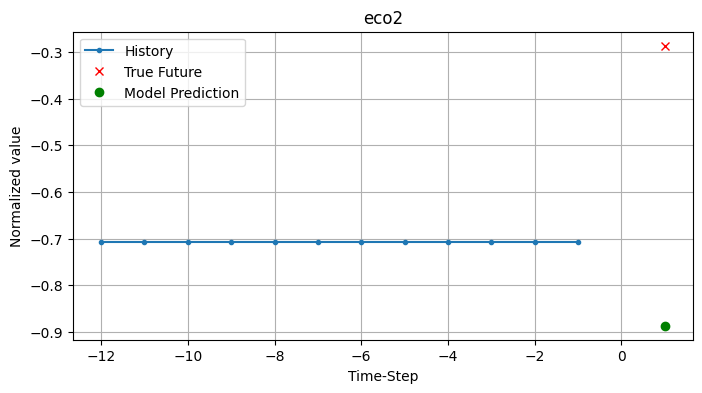

In [30]:
# @title
for x, y in val_ds.take(3):
  predictions = lstm_model.predict(x)
  show_plot(
        x[0, :, 0].numpy(),              # history (time_steps,)
        y["eco2"][0].numpy(),            # true future
        predictions[0][0][0],            # model prediction
        "eco2"
        )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


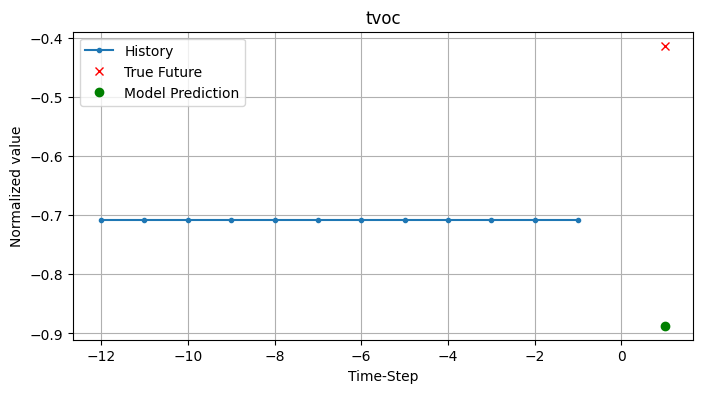

In [31]:
# @title
for x, y in val_ds.take(3):
  predictions = lstm_model.predict(x)
  show_plot(
        x[0, :, 0].numpy(),              # history (time_steps,)
        y["tvoc"][0].numpy(),            # true future
        predictions[0][0][0],            # model prediction
        "tvoc"
        )

# Plot some unnormalized results

In [32]:
# Fetch true temperatures

y_true_temp = []

for x, y in test_ds:
  y_true_temp.append(y['temperature'])

y_true_temp = tf.concat(y_true_temp, axis=0).numpy()

In [33]:
# Perform some predictions

predictions = lstm_model.predict(test_ds)
y_predicted_temp = predictions[0].squeeze() # Predicted temperature output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


In [34]:
# Dynamically written unnorm method
# Returns unnormalized values

def unnorm(y_true, y_pred, attribute):
  y_true_attr = (
      y_true* train_std[attribute]
      + train_mean[attribute]
  )

  y_pred_attr = (
      y_pred * train_std[attribute]
      + train_mean[attribute]
  )
  return y_true_attr, y_pred_attr

In [35]:
# Call unnorm method with temperature attribute

y_true_temp_unnormalized, y_pred_temp_unnormalized = unnorm(
    y_true_temp,
    y_predicted_temp,
    "temperature"
)

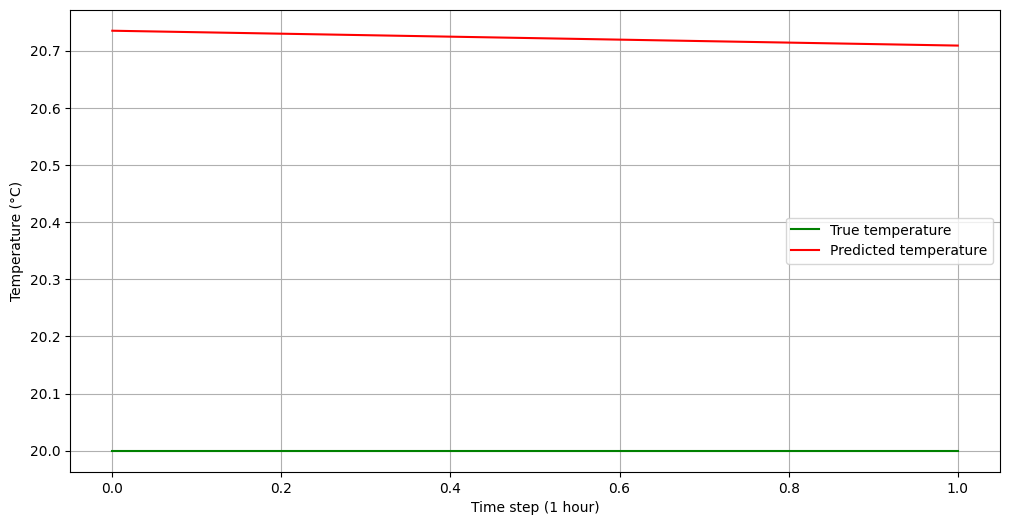

In [36]:
plt.figure(figsize=(12,6))
plt.plot(y_true_temp_unnormalized, label="True temperature", color="green", alpha=1)
plt.plot(y_pred_temp_unnormalized, label="Predicted temperature", color="red", alpha=1)
plt.ylabel("Temperature (°C)")
plt.xlabel("Time step (1 hour)")
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# Call unnorm method with eco2 attribute

y_true_temp_unnormalized, y_pred_temp_unnormalized = unnorm(
    y_true_temp,
    y_predicted_temp,
    "eco2"
)

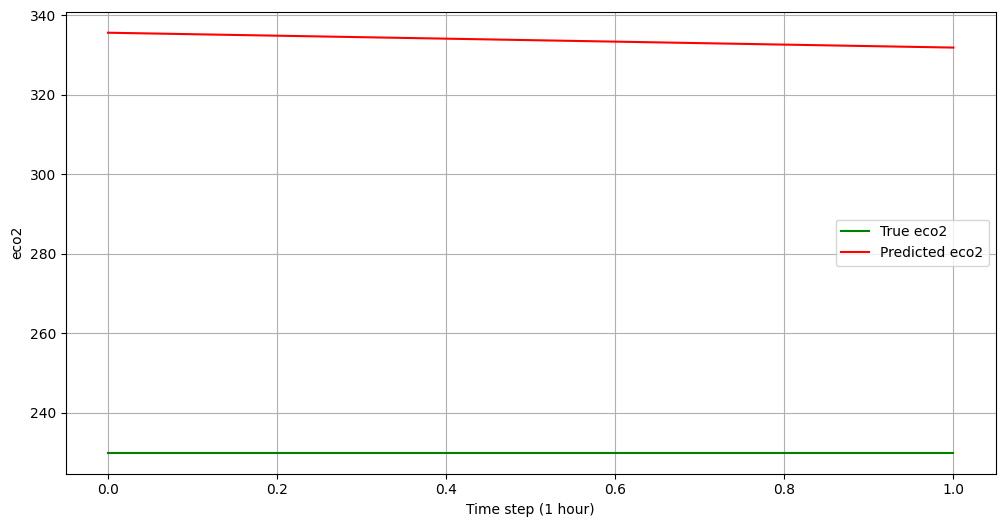

In [42]:
plt.figure(figsize=(12,6))
plt.plot(y_true_temp_unnormalized, label="True eco2", color="green", alpha=1)
plt.plot(y_pred_temp_unnormalized, label="Predicted eco2", color="red", alpha=1)
plt.ylabel("eco2")
plt.xlabel("Time step (1 hour)")
plt.legend()
plt.grid(True)
plt.show()

# Forecasting several time steps (hours) ahead
**Reference to all code blocks below: Géron, A. ss. 505-511**

**Forecasting several time steps ahead**

In [37]:
# One step is 1 hour

def recursive_func(model, start_window, steps):
  predictions = []
  window = start_window.numpy().copy()

  for step_ahead in range(steps):
    predictions_output = model.predict(window)
    predictions_output = np.concatenate(predictions_output, axis = 1) # Convert list to array
    predictions.append(predictions_output[0])

    # Push window one timestep ahead
    window = np.concatenate([window[:, 1:, :], predictions_output[:, None, :]], axis=1)

  return np.array(predictions)

**Perform predictions**

In [38]:
# Fetch from test dataset
steps=12 # Feel free to alter this variable and rerun from this cell and below to perform predictions from 1-14 steps

for x, y in test_ds.take(1):
  start_window = x[0:1]
  break
predictions = recursive_func(lstm_model, start_window, steps)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


**We need to fetch the true future in order to compare our predicted values**

In [39]:
start_index = split2ix # The beginning of the test data which we already declared in the beginning of the file

true_future = df_1h.iloc[start_index + steps][["temperature", "humidity", "eco2", "tvoc"]].values # Fetch and store true values from where test data starts and 12 hours (steps) ahead

In [40]:
pred_real = predictions * train_std.values + train_mean.values
last_pred = pred_real[-1]

print(
      steps, "hours ahead:\n"
      "Temperature:", f"{last_pred[0]:.4f}\n",
      "Humidity:", f"{last_pred[1]:.4f}\n",
      "eCO2:", f"{last_pred[2]:.4f}\n",
      "TVOC:", f"{last_pred[3]:.4f}\n"
    )

print(
    "True future values:\n",
    "Temperature:", f"{true_future[0]:.4f}\n",
      "Humidity:", f"{true_future[1]:.4f}\n",
      "eCO2:", f"{true_future[2]:.4f}\n",
      "TVOC:", f"{true_future[3]:.4f}\n"
)

12 hours ahead:
Temperature: 20.7414
 Humidity: 39.0665
 eCO2: 390.2659
 TVOC: 41.3076

True future values:
 Temperature: 20.0000
 Humidity: 47.7921
 eCO2: 400.0000
 TVOC: 0.0000

